In [ ]:
from src.sampling.images import plot_frame_count_distributions

samples_root_dir = "data/samples"

plot_frame_count_distributions(samples_root_dir)

In [ ]:
class Test:

    def func():
        pass

x = Test()
x.func.__name__

# Sota K-Fold cross validation

In [1]:
from src.sota.model import SOTAFoldCrossValidation, MultiRunSOTATrainArgs

cross_validation = SOTAFoldCrossValidation(data_root="data", 
    model_name="yolo11n-cls", 
    train_run_args=MultiRunSOTATrainArgs(runs=1, epochs=1, balanced=False),
    dataset_name="techniques",
    yolo_model="yolo11n-cls")

cross_validation.train_folds()

/mnt/c/Projects/climbing-technique-detector/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


Building fold 1 ...
Fold 1: Train size = 4373, Val size = 568, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


wandb: Currently logged in as: tom-decoutere (tom-decoutere-open-universiteit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f1, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

E0000 00:00:1753974728.639051   16333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753974728.944330   16333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4373 images, 0 corrupt: 100%|██████████| 4373/4373 [01:17<00:00, 56.12it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 568 images, 0 corrupt: 100%|██████████| 568/568 [00:10<00:00, 53.47it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f1/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:06<00:00,  2.57it/s]


                   all      0.674      0.991


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 185.19it/s]



1 epochs completed in 0.025 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f1/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f1/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f1/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4373 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 568 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.71it/s]


                   all       0.68      0.993


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 187.89it/s]

Speed: 0.4ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f1/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa81397e240>
curves: []
curves_results: []
fitness: 0.8362676203250885
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6795774698257446, 'metrics/accuracy_top5': 0.9929577708244324, 'fitness': 0.8362676203250885}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f1/train')
speed: {'preprocess': 0.44339238916044976, 'inference': 0.6420218309819613, 'loss': 0.00024557924865495784, 'postprocess': 0.0012995070891789304}
task: 'classify'
top1: 0.6795774698257446
top5: 0.9929577708244324
loading the model 'yolo11n-cls-f1' with the weights at 'data/runs/sota/yolo11n-cls-f1/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4373 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:11<00:00, 48.29it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]


                   all      0.694      0.991


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Speed: 0.6ms preprocess, 1.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f1/test


Building fold 2 ...
Fold 2: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f2, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:39<00:00, 43.86it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:10<00:00, 51.18it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f2/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s]


                   all      0.688      0.969


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 163.61it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f2/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f2/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f2/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


                   all      0.695      0.969


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 151.90it/s]

Speed: 0.5ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f2/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa754161520>
curves: []
curves_results: []
fitness: 0.8321364521980286
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6947935223579407, 'metrics/accuracy_top5': 0.9694793820381165, 'fitness': 0.8321364521980286}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f2/train')
speed: {'preprocess': 0.4808986841143348, 'inference': 0.638468705543653, 'loss': 0.0030972171492065358, 'postprocess': 0.009792605074309816}
task: 'classify'
top1: 0.6947935223579407
top5: 0.9694793820381165
loading the model 'yolo11n-cls-f2' with the weights at 'data/runs/sota/yolo11n-cls-f2/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:12<00:00, 43.24it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:11<00:00,  3.00it/s]


                   all      0.745      0.984


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Speed: 0.5ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f2/test


Building fold 3 ...
Fold 3: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f3, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:51<00:00, 39.29it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:13<00:00, 42.20it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f3/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.69it/s]


                   all      0.715      0.966


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 194.71it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f3/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f3/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f3/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.86it/s]


                   all      0.718      0.966


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 177.22it/s]

Speed: 0.5ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f3/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa801f8be00>
curves: []
curves_results: []
fitness: 0.8420107662677765
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7181328535079956, 'metrics/accuracy_top5': 0.9658886790275574, 'fitness': 0.8420107662677765}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f3/train')
speed: {'preprocess': 0.4797053464945018, 'inference': 0.7384544829093923, 'loss': 0.0050148401134338105, 'postprocess': 0.00845243972709446}
task: 'classify'
top1: 0.7181328535079956
top5: 0.9658886790275574
loading the model 'yolo11n-cls-f3' with the weights at 'data/runs/sota/yolo11n-cls-f3/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:12<00:00, 44.97it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]


                   all      0.716      0.996


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Speed: 0.5ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f3/test


Building fold 4 ...
Fold 4: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f4, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:51<00:00, 39.30it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:16<00:00, 33.96it/s]


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f4/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]


                   all      0.671      0.969


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 184.49it/s]



1 epochs completed in 0.022 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f4/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f4/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f4/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all       0.67      0.969


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 160.98it/s]

Speed: 0.4ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f4/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa7bfb627b0>
curves: []
curves_results: []
fitness: 0.8195691406726837
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.669658899307251, 'metrics/accuracy_top5': 0.9694793820381165, 'fitness': 0.8195691406726837}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f4/train')
speed: {'preprocess': 0.4293023374749271, 'inference': 0.8585486805385825, 'loss': 0.00038792093282756084, 'postprocess': 0.0010093986420412306}
task: 'classify'
top1: 0.669658899307251
top5: 0.9694793820381165
loading the model 'yolo11n-cls-f4' with the weights at 'data/runs/sota/yolo11n-cls-f4/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:15<00:00, 34.57it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]


                   all      0.699      0.973


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f4/test


Building fold 5 ...
Fold 5: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f5, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:49<00:00, 39.89it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:13<00:00, 40.36it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f5/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  4.47it/s]


                   all      0.688      0.975


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 181.85it/s]



1 epochs completed in 0.022 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f5/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f5/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f5/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


                   all      0.693      0.975


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 159.60it/s]

Speed: 0.4ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f5/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa801c81ee0>
curves: []
curves_results: []
fitness: 0.8339318037033081
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6929982304573059, 'metrics/accuracy_top5': 0.9748653769493103, 'fitness': 0.8339318037033081}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f5/train')
speed: {'preprocess': 0.4497549785121346, 'inference': 0.849523655342898, 'loss': 0.0003036463765270299, 'postprocess': 0.000841192087272259}
task: 'classify'
top1: 0.6929982304573059
top5: 0.9748653769493103
loading the model 'yolo11n-cls-f5' with the weights at 'data/runs/sota/yolo11n-cls-f5/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:08<00:00, 63.66it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s]


                   all      0.714      0.978


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f5/test


Building fold 6 ...
Fold 6: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f6, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:51<00:00, 39.48it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:13<00:00, 41.77it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f6/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


                   all      0.709      0.977


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 208.14it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f6/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f6/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f6/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]


                   all      0.706      0.978


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 160.16it/s]

Speed: 0.5ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f6/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa7d7b709e0>
curves: []
curves_results: []
fitness: 0.8420107662677765
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7055655121803284, 'metrics/accuracy_top5': 0.9784560203552246, 'fitness': 0.8420107662677765}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f6/train')
speed: {'preprocess': 0.4538153356197834, 'inference': 0.7446192333385301, 'loss': 0.00028835014520376865, 'postprocess': 0.0007184166118462488}
task: 'classify'
top1: 0.7055655121803284
top5: 0.9784560203552246
loading the model 'yolo11n-cls-f6' with the weights at 'data/runs/sota/yolo11n-cls-f6/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:16<00:00, 33.71it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.25it/s]


                   all      0.689      0.965


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f6/test


Building fold 7 ...
Fold 7: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f7, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:50<00:00, 39.69it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:16<00:00, 34.16it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f7/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]


                   all      0.716      0.966


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 184.32it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f7/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f7/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f7/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all      0.715      0.968


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 181.44it/s]

Speed: 0.5ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f7/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa81397d3a0>
curves: []
curves_results: []
fitness: 0.8411131203174591
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7145422101020813, 'metrics/accuracy_top5': 0.9676840305328369, 'fitness': 0.8411131203174591}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f7/train')
speed: {'preprocess': 0.49030278826924967, 'inference': 0.7110661723570734, 'loss': 0.007311922633482053, 'postprocess': 0.003830192259912458}
task: 'classify'
top1: 0.7145422101020813
top5: 0.9676840305328369
loading the model 'yolo11n-cls-f7' with the weights at 'data/runs/sota/yolo11n-cls-f7/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:08<00:00, 66.01it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]


                   all      0.707      0.985


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Speed: 0.6ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f7/test


Building fold 8 ...
Fold 8: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f8, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:49<00:00, 39.87it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:16<00:00, 33.82it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f8/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


                   all      0.689      0.977


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 187.63it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f8/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f8/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f8/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]


                   all      0.697      0.971


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 167.86it/s]

Speed: 0.4ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f8/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa886066fc0>
curves: []
curves_results: []
fitness: 0.8339317739009857
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6965888738632202, 'metrics/accuracy_top5': 0.9712746739387512, 'fitness': 0.8339317739009857}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f8/train')
speed: {'preprocess': 0.4315640503763015, 'inference': 0.8899814022255181, 'loss': 0.000778062796200119, 'postprocess': 0.002283850884151978}
task: 'classify'
top1: 0.6965888738632202
top5: 0.9712746739387512
loading the model 'yolo11n-cls-f8' with the weights at 'data/runs/sota/yolo11n-cls-f8/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:08<00:00, 61.04it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.89it/s]


                   all      0.709      0.985


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Speed: 0.5ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f8/test


Building fold 9 ...
Fold 9: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f9, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:52<00:00, 39.04it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:13<00:00, 41.44it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f9/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.70it/s]


                   all      0.684      0.973


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 219.85it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f9/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f9/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f9/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]


                   all      0.689      0.971


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 181.61it/s]

Speed: 0.4ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f9/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa78488ad50>
curves: []
curves_results: []
fitness: 0.830341100692749
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6894075274467468, 'metrics/accuracy_top5': 0.9712746739387512, 'fitness': 0.830341100692749}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f9/train')
speed: {'preprocess': 0.40436827827828536, 'inference': 0.8589269478301245, 'loss': 0.00023343095587670162, 'postprocess': 0.0008040915483264403}
task: 'classify'
top1: 0.6894075274467468
top5: 0.9712746739387512
loading the model 'yolo11n-cls-f9' with the weights at 'data/runs/sota/yolo11n-cls-f9/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:09<00:00, 59.84it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]


                   all      0.689      0.982


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Speed: 0.5ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f9/test


Building fold 10 ...
Fold 10: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11n-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11n-cls-f10, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:50<00:00, 39.85it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:16<00:00, 34.43it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11n-cls-f10/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.88it/s]


                   all      0.697      0.968


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 2,807,024 parameters, 0 gradients, 4.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 191.71it/s]



1 epochs completed in 0.023 hours.
Optimizer stripped from data/runs/sota/yolo11n-cls-f10/train/weights/last.pt, 3.2MB
Optimizer stripped from data/runs/sota/yolo11n-cls-f10/train/weights/best.pt, 3.2MB

Validating data/runs/sota/yolo11n-cls-f10/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


                   all      0.707      0.966


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 186.93it/s]

Speed: 0.5ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f10/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa8022c9520>
curves: []
curves_results: []
fitness: 0.8366247713565826
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7073608636856079, 'metrics/accuracy_top5': 0.9658886790275574, 'fitness': 0.8366247713565826}
save_dir: PosixPath('data/runs/sota/yolo11n-cls-f10/train')
speed: {'preprocess': 0.4651147449603121, 'inference': 0.8244450844463156, 'loss': 0.0002481563445648824, 'postprocess': 0.0006219622853782221}
task: 'classify'
top1: 0.7073608636856079
top5: 0.9658886790275574
loading the model 'yolo11n-cls-f10' with the weights at 'data/runs/sota/yolo11n-cls-f10/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:11<00:00, 47.53it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]


                   all      0.725       0.98


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11n-cls summary (fused): 47 layers, 1,534,991 parameters, 0 gradients, 3.2 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11n-cls-f10/test


FileNotFoundError: [Errno 2] No such file or directory: 'data/runs/sota/yolo11n-cls-full-balanced/test/metrics.json'

Average Top 1 accuracy: 0.7085610270500183


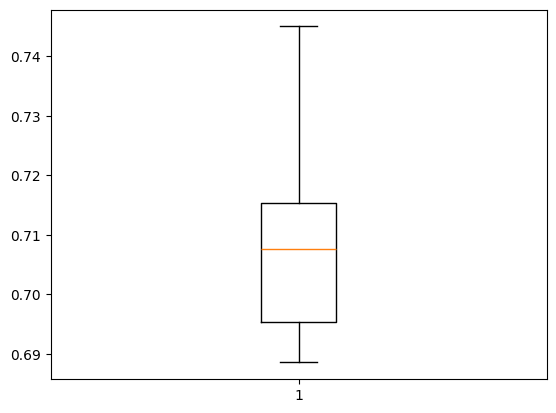

In [8]:
%matplotlib inline
cross_validation.print_box_plot()

In [7]:
from os import listdir
from os.path import join
from src.sota.model import SOTA
from numpy import average
import matplotlib.pyplot as plt

def calculate_avg_test_performance(data_root, base_name):
    model_root = join(data_root, "runs", "sota")
    fold_models = [model_path for model_path in listdir(model_root) if f"{base_name}-f" in model_path]
    metrics = []
    for fold_model in fold_models:
        sota = SOTA("data", fold_model)
        metrics.append(sota.get_test_metrics()["metrics/accuracy_top1"])

    print(f"Average Top 1 accuracy: {average(metrics)}")
    
    plt.figure()
    plt.boxplot(metrics)
    plt.show()

calculate_avg_test_performance("data", "yolo11n-cls")

Average Top 1 accuracy: 0.7085610270500183


<Figure size 640x480 with 1 Axes>

In [ ]:
from glob import glob

data_root = "data/img/techniques_kf"

filenames = glob(data_root + "/all/**/*.*", recursive=True)

In [ ]:
from os.path import join
from glob import glob


path_to_all = join("data", "img", "techniques_kf", "all")
glob(path_to_all + "/**/*.*", recursive=True)

In [ ]:
from os import listdir
from os.path import join
from shutil import rmtree, copy
from random import random
from numpy import average
import matplotlib.pyplot as plt

from src.sampling.images import build_image_dirs
from src.sota.model import SOTA

def build_fold(data_root, fold_idx, train_idx, test_idx, filenames):
    fold_num = fold_idx + 1
    build_image_dirs(join(data_root, "current_fold"))
    print(f"Building fold {fold_num} ...")
    train_ratio = 0.9

    for filename_idx in train_idx:
        src = filenames[filename_idx]
        dest = src.replace("/all/", "/current_fold/train/")  \
            if random() < train_ratio \
            else src.replace("/all/", "/current_fold/val/")
        
        copy(src, dest)

    for filename_idx in test_idx:
        src = filenames[filename_idx]
        dest = src.replace("/all/", "/current_fold/test/")
        copy(src, dest)

    train_len = len(glob(data_root + "/current_fold/train/**/*.*", recursive=True))
    val_len = len(glob(data_root + "/current_fold/val/**/*.*", recursive=True))
    test_len = len(glob(data_root + "/current_fold/test/**/*.*", recursive=True))
    print(f"Fold {fold_num}: Train size = {train_len}, Val size = {val_len}, Test size = {test_len}")
    
def clear_fold(data_root):
    rmtree(join(data_root, "current_fold"))

def calculate_avg_test_performance(data_root, base_name):
    model_root = join(data_root, "runs", "sota")
    fold_models = [model_path for model_path in listdir(model_root) if f"{base_name}-f" in model_path]
    metrics = []
    for fold_model in fold_models:
        sota = SOTA("data", fold_model)
        metrics.append(sota.get_test_metrics()["metrics/accuracy_top1"])

    print(f"Average Top 1 accuracy: {average(metrics)}")
    
    plt.figure()
    plt.boxplot(metrics)
    plt.show()

In [ ]:
8/9

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

for i, (train, test) in enumerate(kf.split(filenames)):
    build_fold(data_root, i, train, test, filenames)

    sota = SOTA("data", f"yolo11m-cls-f{i + 1}", dataset_name="techniques_kf/current_fold")
    sota.execute_train_runs(model="yolo11m-cls", runs=1, epochs=5, balanced=False)

    sota.test_model(write_to_wandb=False)

    clear_fold(data_root)

    if (i == 1):
        break


In [ ]:
from src.sota.model import SOTA
sota = SOTA("data", "yolo11m-cls")
sota.test_model(write_to_wandb=False)
    

In [ ]:
calculate_avg_test_performance("data", "yolo11m-cls")

In [ ]:
clear_fold(data_root)

## Sota model training 

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-cls")
sota.execute_train_runs(model="yolo11m-cls", runs=3, epochs=10, balanced=False)
#sota.train_model(optimizer="AdamW", lr0=0.0005)

#metrics = model.val(data="data/img/techniques/val")

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-cls")
sota.execute_train_runs(model="yolo11n-cls", runs=5, epochs=10, balanced=False)

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-cls-balanced")
sota.execute_train_runs(model="yolo11m-cls", runs=5, epochs=10, balanced=True)

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-cls-full-balanced")
sota.execute_train_runs(model="yolo11n-cls", runs=2, epochs=5, balanced=True)

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-balance-50-155", dataset_name="techniques_balanced")
sota.initialize_model("yolo11m-cls")
sota.train_model()

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-balance-50-155", dataset_name="techniques_balanced")
sota.initialize_model("yolo11n-cls")
#sota.train_model()
sota.test_model()

# Sota model testing

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-cls")
metrics = sota.test_model(write_to_wandb=False)

print(metrics)

In [ ]:
metrics.top1

## HPE DNN model training

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1")
hpednn.execute_train_runs(runs=5, epochs=10, augment=True)

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1-balanced")
hpednn.execute_train_runs(runs=5, epochs=10, augment=True, balanced=True)

In [ ]:
%load_ext tensorboard

from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_balanced", "techniques_balanced")
hpednn.initialize_model()
hpednn.train_model()

In [ ]:
from os.path import join
run_dir = join("data", "sota", "yolo11n-cls-full-balanced")
run_dir

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_balanced_augmented", "techniques_balanced")
hpednn.initialize_model()
hpednn.train_model(augment=True)

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch2_balanced", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH2)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch3_balanced", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH3)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_full_balanced")
hpednn.execute_train_runs(runs=2, epochs=10, augment=True, balanced=True)

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch1_balanced_not_norm", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH1, normalize=False)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch1_balanced_dr_0.3", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH1, dropout_rate=0.3)
hpednn.train_model()

In [ ]:
%tensorboard --logdir data/runs/hpe_dnn/arch1_balanced/train1/logs/train

In [ ]:
from src.hpe_dnn.model import read_data

df_path = "data/df/techniques/train.pkl"
train = read_data(df_path)